### EDA

In [2]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [19]:
import os
print(os.getcwd())
# os.chdir('..')
print(os.getcwd())

/Users/lorenzogiambra/Documents/Uni/Associations/Minerva---Weather-Derivatives/Data
/Users/lorenzogiambra/Documents/Uni/Associations/Minerva---Weather-Derivatives/Data


Old dataset (kept for reference)

In [3]:
df = pd.read_csv("Data/gsod_station_722860.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'Data/gsod_station_722860.csv'

Checking NAs

In [ ]:
# Show number of missing values per column
print(df.isna().sum())

# Or as a percentage of total
print(df.isna().mean() * 100)

Unnamed: 0    0
date          0
temp          0
max           0
min           0
dtype: int64
Unnamed: 0    0.0
date          0.0
temp          0.0
max           0.0
min           0.0
dtype: float64


In [42]:
temp_cols = ['temp', 'max', 'min']
print(df[temp_cols].isna().sum())


temp    0
max     0
min     0
dtype: int64


Checking Outliers

In [43]:
df['date'] = pd.to_datetime(df['date'])

In [45]:
max_outliers = df[df['max'] > 50]
print(max_outliers)

       Unnamed: 0       date   temp      max   min  year
13463       13463 1969-12-15   8.78  5537.72 -2.78  1969
14722       14722 1973-05-27  19.33  5537.72  7.72  1973
15607       15607 1975-10-29  16.56  5537.72  7.22  1975
28815       28815 2011-12-28   8.22  5537.72 -2.50  2011
28818       28818 2011-12-31  11.56  5537.72  1.72  2011
31007       31007 2017-12-28  11.44  5537.72  1.22  2017
32089       32089 2020-12-20   8.89  5537.72 -1.78  2020


In [46]:
min_outliers = df[df['min'] > 50]
print(min_outliers)

       Unnamed: 0       date   temp    max      min  year
7               7 1933-01-08  14.44  23.50  5537.72  1933
164           164 1933-06-14  33.17  38.89  5537.72  1933
12673       12673 1967-10-17  22.61  35.50  5537.72  1967
22929       22929 1995-11-15  11.83  23.78  5537.72  1995


Removing Outliers

In [ ]:
import numpy as np

# Replace outliers with NaN for MAX and MIN
threshold_max = 100   # adjust according to realistic limits for your dataset

df.loc[df['max'] > threshold_max, 'max'] = np.nan
df.loc[df['min'] > threshold_max, 'min'] = np.nan

# Optionally, interpolate missing values
df['max'] = df['max'].interpolate(method='linear')
df['min'] = df['min'].interpolate(method='linear')

# Check the stats to confirm values are now within a realistic range
print(df[['date', 'max', 'min']].describe())

                                date           max           min
count                          33651  33651.000000  33651.000000
mean   1979-02-25 22:18:40.085584320     25.608117      9.812687
min              1933-01-01 00:00:00      3.000000     -8.280000
25%              1956-02-16 12:00:00     20.000000      5.610000
50%              1979-02-28 00:00:00     25.500000     10.000000
75%              2002-03-12 12:00:00     31.720000     13.890000
max              2025-03-31 00:00:00     46.500000     34.110000
std                              NaN      7.414279      5.632309


New dataset

In [3]:
import os

# View current working directory
print("Current working directory:", os.getcwd())

# Step 1: Go one level up from the current directory
parent_dir = os.path.dirname(os.getcwd())
print("Parent directory:", parent_dir)

# Step 2: Go to the desired folder
new_directory = os.path.join(parent_dir, "Data")

# Change directory to the desired folder
# new_directory = r"C:\Users\giamb\OneDrive\Documents\2 Uni\Associations\4 Minerva\1 Weather Derivatives\Minerva---Weather-Derivatives\Data"
# Change to the Data folder inside your current project

os.chdir(new_directory)

# Step 3: Confirm new working directory
print("New working directory:", new_directory)

Current working directory: /Users/lorenzogiambra/Documents/Uni/Associations/Minerva---Weather-Derivatives/CNN-LSTM Model
Parent directory: /Users/lorenzogiambra/Documents/Uni/Associations/Minerva---Weather-Derivatives
New working directory: /Users/lorenzogiambra/Documents/Uni/Associations/Minerva---Weather-Derivatives/Data


In [4]:
df = pd.read_csv("full_cleaned_data.csv")

Checking Average, Max, Min Temperature Trends Over the Years

           mean        max        min
year                                 
1933  20.335956  24.474238  12.238248
1934  21.830904  25.949918  13.858055
1935  20.128548  23.932411  12.612110
1936  17.528989  25.632623  10.377842
1937  16.304521  25.044137   9.338137
...         ...        ...        ...
2020  17.449317  28.056417   7.640164
2021  17.868956  27.377500   9.182555
2022  18.536164  27.958274  10.072438
2023  16.591973  25.499260   8.533973
2024  17.400109  27.087541   8.751421

[92 rows x 3 columns]


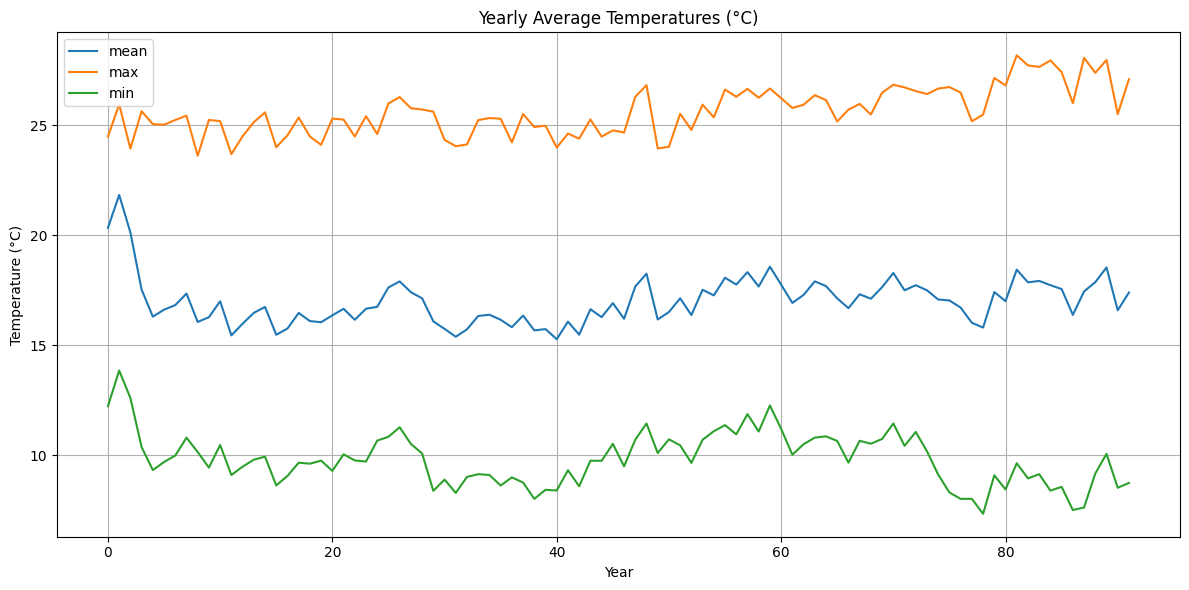

In [26]:
# Extract year for grouping
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
temp_cols = ['mean', 'max', 'min']

# Group by year and calculate mean
yearly_trends = df.groupby('year')[temp_cols].mean()
yearly_trends = yearly_trends[yearly_trends.index < 2025]
print(yearly_trends)
yearly_trends.reset_index(inplace=True)


plt.figure(figsize=(12, 6))
for col in temp_cols:
    plt.plot(yearly_trends.index, yearly_trends[col], label=col)

plt.title("Yearly Average Temperatures (°C)")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Checking Difference Between Max and Min Temperature Over the Years

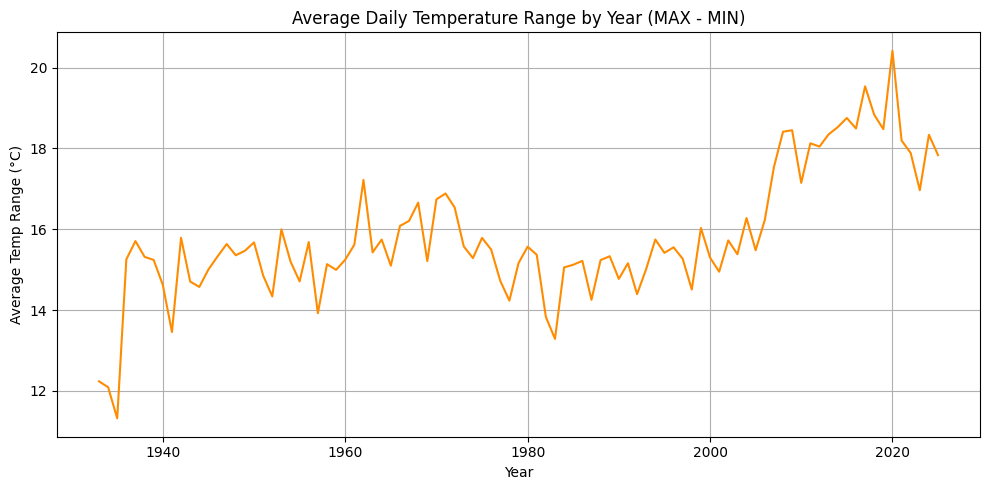

In [27]:
# Add a new column for the daily range
df['temp_range'] = df['max'] - df['min']

# Group by year and calculate average range
temp_range_by_year = df.groupby('year')['temp_range'].mean()

# Plot the average temp range
plt.figure(figsize=(10, 5))
plt.plot(temp_range_by_year.index, temp_range_by_year.values, color='darkorange')
plt.title("Average Daily Temperature Range by Year (MAX - MIN)")
plt.xlabel("Year")
plt.ylabel("Average Temp Range (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()


year
1933    361
1934    365
1935    365
1936    366
1937    365
1938    365
1939    365
1940    366
1941    335
1942    365
1943    365
1944    366
1945    365
1946    365
1947    365
1948    366
1949    365
1950    365
1951    365
1952    366
1953    365
1954    365
1955    365
1956    366
1957    365
1958    365
1959    365
1960    366
1961    365
1962    365
1963    365
1964    366
1965    365
1966    365
1967    365
1968    366
1969    365
1970    365
1971    365
1972    366
1973    365
1974    365
1975    365
1976    366
1977    365
1978    365
1979    365
1980    366
1981    365
1982    365
1983    365
1984    366
1985    365
1986    365
1987    365
1988    366
1989    365
1990    365
1991    365
1992    366
1993    365
1994    365
1995    365
1996    366
1997    365
1998    365
1999    364
2000    366
2001    365
2002    365
2003    365
2004    366
2005    365
2006    365
2007    365
2008    366
2009    365
2010    365
2011    365
2012    366
2013    365
2014    365
2015    365

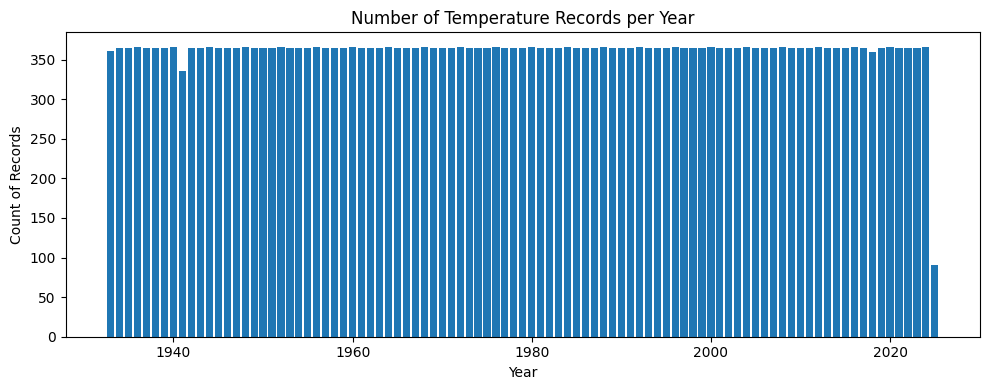

In [28]:
# Count number of measurements per year
freq_by_year = df.groupby('year').size()
print(freq_by_year.to_string())

# Plot number of records per year
plt.figure(figsize=(10, 4))
plt.bar(freq_by_year.index, freq_by_year.values)
plt.title("Number of Temperature Records per Year")
plt.xlabel("Year")
plt.ylabel("Count of Records")
plt.tight_layout()
plt.show()

### Test-Train Split

In [5]:
df_train = pd.read_csv("train_data.csv")
df_test = pd.read_csv("test_data.csv")

print("Train dataset head", df_train.head())
print("Test dataset head", df_test.head())
print("Train dataset shape", df_train.shape)
print("Test dataset shape", df_test.shape)

Train dataset head          date   mean    max   min
0  1933-01-01  13.67  18.89  2.78
1  1933-01-02  13.89  19.61  1.89
2  1933-01-03  10.83  16.28  0.78
3  1933-01-04  14.94  21.28  1.28
4  1933-01-05  18.11  23.50  6.89
Test dataset head          date   mean    max   min
0  2024-04-01  10.33  20.39  3.61
1  2024-04-02  13.22  24.22  4.50
2  2024-04-03  14.72  24.39  3.72
3  2024-04-04  12.28  24.22  5.11
4  2024-04-05   8.22  16.89  3.50
Train dataset shape (33286, 4)
Test dataset shape (365, 4)


In [6]:
# # Create train and test sets for the selected features (without shuffling for time series)
# df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)

# print("Train dataset shape:", df_train.shape)
# print("Test dataset shape:", df_test.shape)

### Feature Scaling

In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Scaler for the features, transforming and scaling
# features = ['mean', 'max', 'min']
# df_train_scaled = df_train.copy()
# x_scaler = MinMaxScaler()
# df_train_scaled[features] = x_scaler.fit_transform(df_train_scaled[features])

# Scaler for the target variable mean, transforming and scaling
df_train_scaled = df_train.copy()
y_scaler = MinMaxScaler()
df_train_scaled['mean'] = y_scaler.fit_transform(df_train_scaled[['mean']])

# Transform the test set using the same scaler, without fitting again
df_test_scaled = df_test.copy()
df_test_scaled['mean'] = y_scaler.transform(df_test[['mean']])

print("Scaled data summary:")
print(df_train_scaled['mean'].describe())

print("Test Scaled data summary:")
print(df_test_scaled['mean'].describe())

Scaled data summary:
count    33286.000000
mean         0.423558
std          0.149234
min          0.000000
25%          0.306928
50%          0.409157
75%          0.540940
max          1.000000
Name: mean, dtype: float64
Test Scaled data summary:
count    365.000000
mean       0.440456
std        0.159001
min        0.164244
25%        0.313469
50%        0.406492
75%        0.576066
max        0.822190
Name: mean, dtype: float64


           mean        max        min
year                                 
1933  20.335956  24.474238  12.238248
1934  21.830904  25.949918  13.858055
1935  20.128548  23.932411  12.612110
1936  17.528989  25.632623  10.377842
1937  16.304521  25.044137   9.338137
...         ...        ...        ...
2020  17.449317  28.056417   7.640164
2021  17.868956  27.377500   9.182555
2022  18.536164  27.958274  10.072438
2023  16.591973  25.499260   8.533973
2024  10.827912  18.255275   4.114176

[92 rows x 3 columns]
Train range:       mean   max    min
min  -0.50   3.0  -8.28
max  40.78  46.5  34.11
Test range:       mean    max    min
min   6.28  11.39  -2.39
max  33.44  44.78  23.50


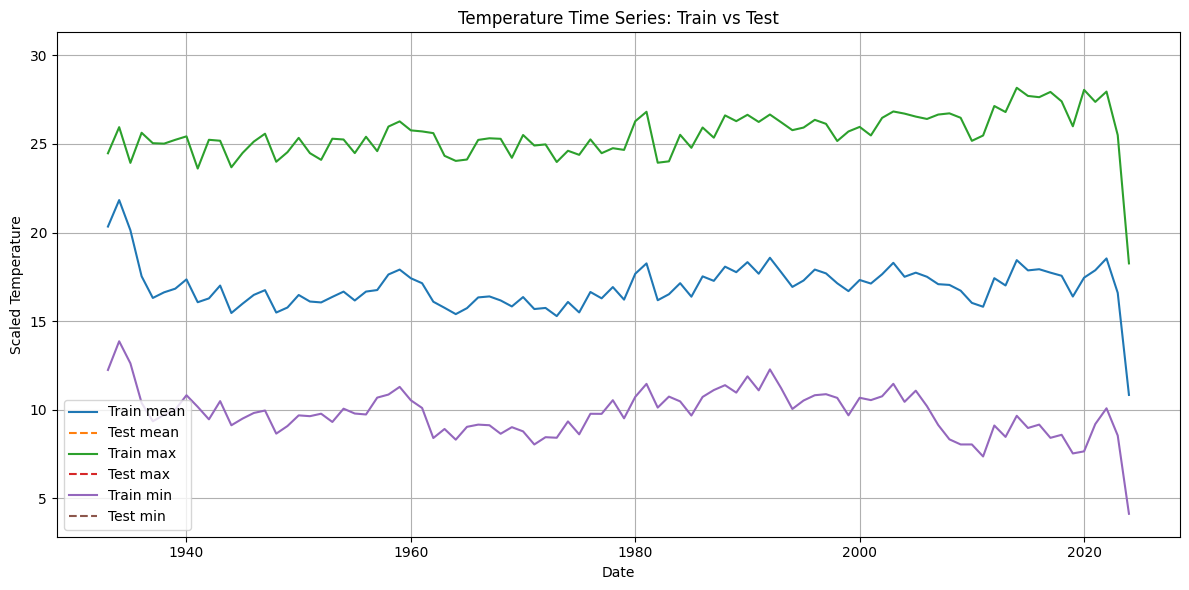

In [8]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['year'] = df_train['date'].dt.year

df_test['date'] = pd.to_datetime(df_test['date'])
df_test['year'] = df_test['date'].dt.year

# Define temp_cols as the list of features.
temp_cols = ['mean', 'max', 'min']

# Group by year and calculate the mean.
yearly_trends_train = df_train.groupby('year')[temp_cols].mean()
yearly_trends_train = yearly_trends_train[yearly_trends_train.index < 2025]
print(yearly_trends_train)

yearly_trends_test = df_test.groupby('year')[temp_cols].mean()
yearly_trends_test = yearly_trends_test[yearly_trends_test.index < 2025]

print("Train range:", df_train[["mean", "max", "min"]].agg(['min', 'max']))
print("Test range:", df_test[["mean", "max", "min"]].agg(['min', 'max']))


plt.figure(figsize=(12, 6))
for col in temp_cols:
    # Plot training data (using the date column for the x-axis)
    plt.plot(yearly_trends_train.index, yearly_trends_train[col], label=f'Train {col}')
    # Plot testing data
    plt.plot(yearly_trends_test.index, yearly_trends_test[col], label=f'Test {col}', linestyle='--')


plt.title("Temperature Time Series: Train vs Test")
plt.xlabel("Date")
plt.ylabel("Scaled Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Correct graphing without taking the mean, just daily

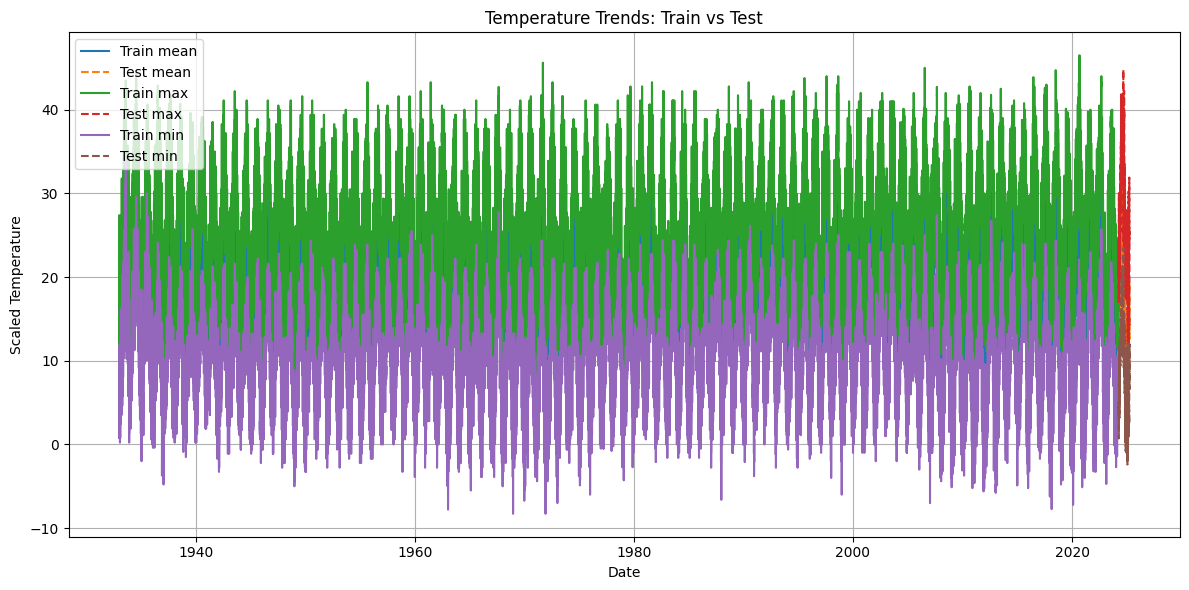

In [9]:
# Assume df_train and df_test still have the date column (set as datetime).
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

plt.figure(figsize=(12,6))
for col in temp_cols:
    plt.plot(df_train['date'], df_train[col], label=f'Train {col}')
    plt.plot(df_test['date'], df_test[col], label=f'Test {col}', linestyle='--')
    
plt.title("Temperature Trends: Train vs Test")
plt.xlabel("Date")
plt.ylabel("Scaled Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### LSTM Training Alessandro

In [34]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scikeras.wrappers import KerasRegressor

# Split data
train_size = int(len(df) * 0.9)
train_data, test_data = df[:train_size], df[train_size:]

# Scale data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

ModuleNotFoundError: No module named 'scikeras'

In [ ]:
# Data preprocessing
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(seq_length, len(data) - 1):
        seq_x = data[i - seq_length:i]

        xs.append(seq_x)
        ys.append(data[i,0])
    return np.array(xs), np.array(ys)


SEQ_LENGTH = 10

X_train, y_train = create_sequences(train_data, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, SEQ_LENGTH)

KeyError: (10, 0)

In [ ]:
def build_lstm_model(OPTIMIZER='adam', LOSS = 'mse', METRICS = ''):
    # Modify the Network Structure
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(SEQ_LENGTH, 3)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Predicting 3 features

    if METRICS != '':
        model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics = METRICS)
    else:
        model.compile(optimizer=OPTIMIZER, loss=LOSS)

    return model

In [ ]:
# Callbacks
checkpoint_cb = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)
early_stopping_cb = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

# Wrap in KerasRegressor
lstm = KerasRegressor(model=build_lstm_model, verbose=0)

randomized = True

lstm = KerasRegressor(build_fn=build_lstm_model, verbose = 0)

# Define search parameters
parameters = {
    'batch_size': [16, 32, 64],
    'epochs': [50, 100],
    'model__optimizer': ['adam', 'rmsprop']
}

# Randomized search
random_search = RandomizedSearchCV(estimator=lstm, param_distributions=parameters, cv=3)

# Fit with callbacks and validation split
random_search.fit(
    X_train, y_train,
    callbacks=[checkpoint_cb, early_stopping_cb],
    validation_split=0.1
)

# parameters = {'batch_size': [16, 32, 64, 128],
#               'epochs': [100, 150],
#               'optimizer': ['adam']}

# if randomized:
#     random_search = RandomizedSearchCV(estimator=lstm, param_distributions=parameters)
#     random_search = random_search.fit(X_train, y_train)#, fit__callbacks = [checkpoint_cb, early_stopping_cb])#, fit_validation_split=.1)
# else:
#     grid_search = GridSearchCV(estimator=lstm, param_grid=parameters)
#     #grid_search = grid_search.fit(X_train, y_train, verbose = 1, callbacks = [checkpoint_cb, early_stopping_cb])

### LSTM Testing Alessandro

### LSTM Training Lorenzo

In [10]:
# Function to create sequences
def create_sequences(data, n_timesteps):
    """
    Converts time series data into sequences for LSTM training.
    
    Parameters:
    - data: numpy array of shape (n_samples, n_features)
    - n_timesteps: number of past time steps to use in each input sequence.
    
    Returns:
    - X: numpy array of input sequences with shape (n_samples - n_timesteps, n_timesteps, n_features)
    - y: numpy array of outputs with shape (n_samples - n_timesteps, n_features)
    """
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        X.append(data[i:i+n_timesteps])
        y.append(data[i+n_timesteps])
    return np.array(X), np.array(y)

# Use only the 'mean' temperature column instead of multiple columns.
# Assuming df_train_scaled is already defined and scaled.
data = df_train_scaled[['mean']].values

# Define the sequence length, e.g., using the previous 30 days
n_timesteps = 30

# Create input and output sequences from the data
X, y = create_sequences(data, n_timesteps)

print("Input shape X:", X.shape)   # Expected shape: (n_samples - n_timesteps, n_timesteps, 1)
print("Output shape y:", y.shape)    # Expected shape: (n_samples - n_timesteps, 1)


Input shape X: (33256, 30, 1)
Output shape y: (33256, 1)


In [11]:
import tensorflow as tf

# Custom learning rate schedule: lr = c / sqrt(t + 1)
class CSqrtSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, c):
        super().__init__()
        self.c = c  # The constant c

    def __call__(self, step):
        # Adding 1 to step to avoid division by zero (when t=0)
        return self.c / tf.sqrt(tf.cast(step + 1, tf.float32))
    
    def get_config(self):
        return {"c": self.c}


In [12]:
c_value = 0.1  # You can adjust this constant as needed
lr_schedule = CSqrtSchedule(c=c_value)
n_features = X.shape[2]  
n_outputs = y.shape[1]   
def create_model(n_timesteps, n_features, n_outputs):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(n_timesteps, n_features)))
    # model.add(LSTM(50))
    model.add(LSTM(50))
    model.add(Dense(n_outputs, activation='elu'))
    model.compile(optimizer=AdamW(learning_rate=lr_schedule), loss='mse')
    return model

# Create the model instance and view the architecture
model = create_model(n_timesteps, n_features, n_outputs)
model.summary()

/opt/anaconda3/envs/tf-env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam

# def create_model(n_timesteps, n_features, n_outputs):
#     model = Sequential([
#         # two LSTM layers as before
#         LSTM(50, return_sequences=True, input_shape=(n_timesteps, n_features)),
#         LSTM(50),
#         # extra Dense to up capacity
#         Dense(32, activation='elu'),
#         # your final output layer
#         Dense(n_outputs, activation='linear')
#     ])
#     model.compile(
#         optimizer=Adam(learning_rate=lr_schedule),
#         loss='mse'
#     )
#     return model

# model = create_model(n_timesteps, n_features, n_outputs)
# model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,265 (126.04 KB)

 Trainable params: 32,265 (126.04 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Set up the ModelCheckpoint callback to save the best model based on validation loss
checkpoint_cb = ModelCheckpoint("best_model.keras", 
                                save_best_only=True, 
                                monitor="val_loss", 
                                mode="min", 
                                verbose=1)

early_stopping_cb = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1)

# Train the model, including the ModelCheckpoint and EarlyStopping callbacks
history = model.fit(X, y, 
                    epochs=100, 
                    batch_size=128,
                    validation_split=0.05,
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
245/247 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7607
Epoch 1: val_loss improved from inf to 0.00779, saving model to best_model.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.7535 - val_loss: 0.0078
Epoch 2/100
246/247 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0079
Epoch 2: val_loss improved from 0.00779 to 0.00693, saving model to best_model.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0079 - val_loss: 0.0069
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0070
Epoch 3: val_loss improved from 0.00693 to 0.00616, saving model to best_model.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0070 - val_loss: 0.0062
Epoch 4/100
246/247 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0064
Epoch 4: val_loss improved from 0.00616 to 0.00558, saving model to best_model.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0064 - val_loss: 0.0056
Epoch 5/100
245/247 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0059
Epoch 5: val_lo

### LSTM Training Lorenzo Hyperparameter tuning

In [74]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import AdamW
from keras_tuner.tuners import BayesianOptimization

# Hypermodel wrapper for LSTM
def build_model(hp):
    model = Sequential()
    
    units_1 = hp.Int("units_1", min_value=32, max_value=128, step=32)
    model.add(LSTM(units_1, return_sequences=True, input_shape=(n_timesteps, n_features)))

    units_2 = hp.Int("units_2", min_value=32, max_value=128, step=32)
    model.add(LSTM(units_2))

    model.add(Dense(n_outputs, activation='elu'))

    c_value = hp.Float("c_value", min_value=0.01, max_value=0.5, sampling="log")
    lr_schedule = CSqrtSchedule(c=c_value)

    model.compile(
        optimizer=AdamW(learning_rate=lr_schedule),
        loss="mse",
        metrics=["mae"]
    )
    return model

In [75]:
# Set up Bayesian optimization tuner
tuner = BayesianOptimization(
    build_model,
    objective="val_loss",
    max_trials=15,
    executions_per_trial=1,
    directory="tuning_dir",
    project_name="weather_lstm_bayes"
)

/opt/anaconda3/envs/tf-env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [76]:
# Early stopping for stability
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Start the hyperparameter search
tuner.search(
    X, y,
    epochs=100,
    validation_split=0.05,
    callbacks=[early_stopping_cb],
    batch_size=kt.HyperParameters().Choice("batch_size", [32, 64, 128, 256]),
    verbose=1
)

Trial 2 Complete [00h 05m 59s]
val_loss: 0.0020708164665848017

Best val_loss So Far: 0.0020708164665848017
Total elapsed time: 00h 16m 38s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
128               |64                |units_1
128               |32                |units_2
0.019209          |0.26662           |c_value

Epoch 1/100
988/988 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.1393 - mae: 0.1309 - val_loss: 0.0056 - val_mae: 0.0603
Epoch 2/100
 22/988 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 0.0060 - mae: 0.0623

KeyboardInterrupt: 

In [ ]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best LSTM units: {best_hps.get('units_1')} & {best_hps.get('units_2')}")
print(f"Best c_value: {best_hps.get('c_value')}")
print(f"Best batch_size: {best_hps.get('batch_size')}")

# Rebuild and retrain the best model
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X, y,
    epochs=150,
    validation_split=0.05,
    batch_size=best_hps.get("batch_size"),
    callbacks=[early_stopping_cb]
)

### LSTM Testing Lorenzo (Incorrect)

In [13]:
def create_test_sequences(data, n_timesteps):
    X_seq = []
    for i in range(len(data) - n_timesteps):
        X_seq.append(data[i:i+n_timesteps])
    return np.array(X_seq)

features = ['mean'] # Use only the 'mean' temperature column for testing, since only want to predict one feature. IMPORTANT

In [29]:
# --- 1) Build your test input from df_test_scaled, not raw df_test ---
X_test = create_test_sequences(
    df_test_scaled[['mean']].values,   # already scaled by y_scaler
    n_timesteps
)
print("Shape of X_test:", X_test.shape)

# --- 2) Predict in scaled space ---
predictions_scaled = model.predict(X_test)    # shape = (n_windows, 1)

# --- 3) Inverse-transform only with your y_scaler ---
predictions_original = y_scaler.inverse_transform(predictions_scaled)

# --- 4) Build a DataFrame of predictions ---
predictions_df = pd.DataFrame(predictions_original, columns=['mean'])
print("Predicted Temperatures (Original Scale):")
print(predictions_df.head())

# --- 5) Grab the true, scaled test values and inverse-transform them ---
actual_scaled = df_test_scaled[['mean']].values[n_timesteps:]
actual_original = y_scaler.inverse_transform(actual_scaled)
actual_df = pd.DataFrame(actual_original, columns=['mean'])

# --- 6) Align and compare ---
comparison_df = pd.concat(
    [actual_df.reset_index(drop=True), predictions_df.reset_index(drop=True)],
    axis=1
)

pd.set_option('display.max_rows', None)
comparison_df.columns = ['Actual mean', 'Predicted mean']
print("Comparison of Actual vs Predicted Temperatures:")
print(str(comparison_df))

print("MSE:", mean_squared_error(comparison_df['Actual mean'],
                                 comparison_df['Predicted mean']))
print("RMSE:", np.sqrt(mean_squared_error(comparison_df['Actual mean'],
                                         comparison_df['Predicted mean'])))
print("MAE:", mean_absolute_error(comparison_df['Actual mean'],
                                  comparison_df['Predicted mean']))
print("R2: ", r2_score(comparison_df['Actual mean'],
                       comparison_df['Predicted mean']))

Shape of X_test: (335, 30, 1)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Predicted Temperatures (Original Scale):
        mean
0  15.914937
1  16.595451
2  15.586545
3  15.453595
4  15.190129
Comparison of Actual vs Predicted Temperatures:
     Actual mean  Predicted mean
0          17.11       15.914937
1          16.17       16.595451
2          15.72       15.586545
3          15.33       15.453595
4          14.11       15.190129
5          13.78       13.995793
6          15.22       13.984798
7          16.28       15.540379
8          16.67       16.190989
9          18.00       16.287489
10         18.28       17.729465
11         17.89       17.661659
12         18.28       17.238073
13         17.28       17.852476
14         16.50       16.642736
15         15.89       16.210016
16         16.61       15.802906
17         17.61       16.757650
18         17.17       17.591940
19         15.50       16.730350
20         16.78       15.159656
21         16.00       17.144121
22  

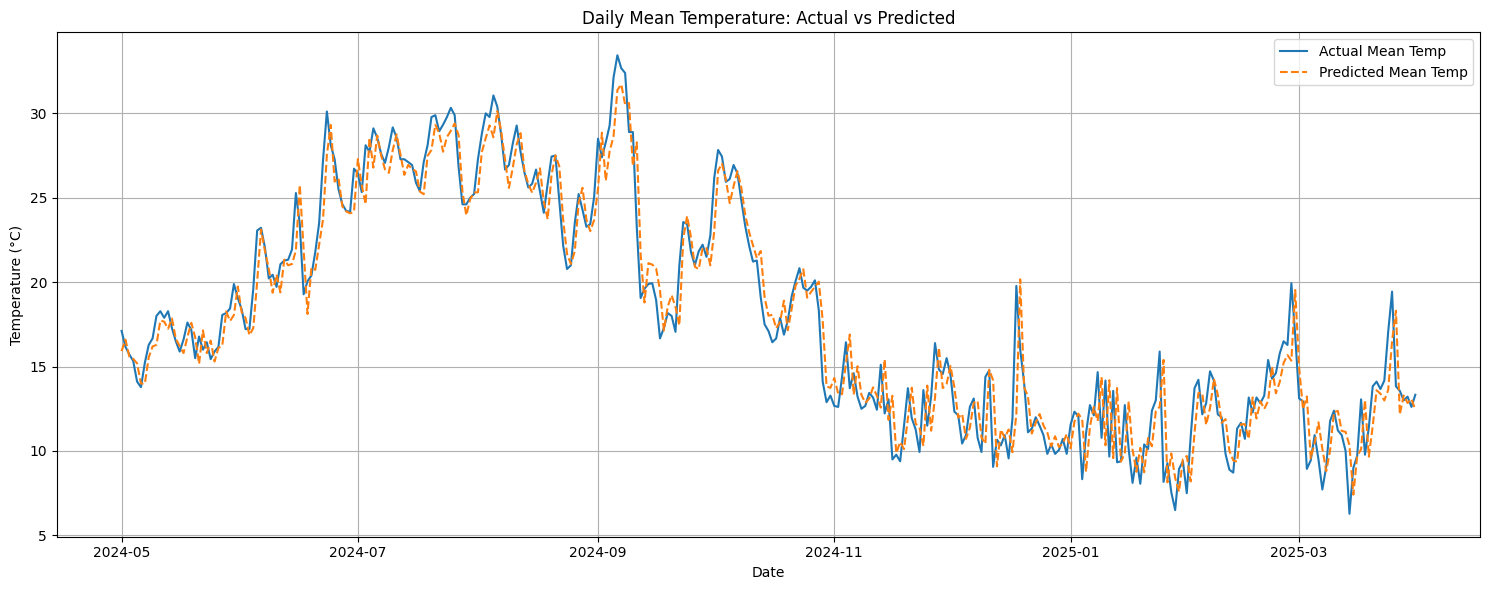

In [30]:
import matplotlib.pyplot as plt

# --- 7) Recover the corresponding dates from the test set ---
# Use the trimmed df_test (after n_timesteps)
aligned_dates = df_test['date'].iloc[n_timesteps:].reset_index(drop=True)

# Add dates to the comparison dataframe
comparison_df['Date'] = aligned_dates

# --- 8) Plot the actual vs predicted mean temperatures ---
plt.figure(figsize=(15, 6))
plt.plot(comparison_df['Date'], comparison_df['Actual mean'], label='Actual Mean Temp')
plt.plot(comparison_df['Date'], comparison_df['Predicted mean'], label='Predicted Mean Temp', linestyle='--')
plt.title("Daily Mean Temperature: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### LSTM Latest and Correct Testing

Doing the recursive multi-step way

In [1]:
# --- Recursive multi-step forecasting on the test set ---

# grab the scaled test series (shape = [n_test_days, 1])
scaled_series = df_test_scaled[['mean']].values.flatten()

# seed history with the first 30 *true* scaled values
history = list(scaled_series[:n_timesteps])
preds_scaled = []

# roll forward one day at a time
for t in range(n_timesteps, len(scaled_series)):
    x_input = np.array(history[-n_timesteps:])      # last 30 values
    x_input = x_input.reshape((1, n_timesteps, 1))  # shape (1,30,1)
    yhat = model.predict(x_input, verbose=0)[0,0]
    preds_scaled.append(yhat)                       # store prediction
    history.append(yhat)                            # feed it back

# convert back to numpy array
preds_scaled = np.array(preds_scaled).reshape(-1,1)

# inverse-transform both predicted and actual
preds = y_scaler.inverse_transform(preds_scaled).flatten()
actual = y_scaler.inverse_transform(
    scaled_series[n_timesteps:].reshape(-1,1)
).flatten()

# align dates
dates = df_test['date'].iloc[n_timesteps:].reset_index(drop=True)

# build comparison DataFrame
comparison = pd.DataFrame({
    'Actual':    actual,
    'Predicted': preds
}, index=dates)

print("Comparison of Actual vs Predicted Temperatures:")
print(comparison.head())

# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("📈 Recursive Multi-Step Backtest 2024-04-01→Now")
print(" MSE :", mean_squared_error(comparison['Actual'], comparison['Predicted']))
print(" RMSE:", np.sqrt(mean_squared_error(comparison['Actual'], comparison['Predicted'])))
print(" MAE :", mean_absolute_error(comparison['Actual'], comparison['Predicted']))
print("  R2 :", r2_score(comparison['Actual'], comparison['Predicted']))

# plot
plt.figure(figsize=(15,6))
plt.plot(comparison.index, comparison['Actual'],    label='Actual',   linewidth=2)
plt.plot(comparison.index, comparison['Predicted'], label='Predicted', linestyle='--')
plt.title("Recursive 1-Day Rolling LSTM — Backtest from 2024-04-01")
plt.xlabel("Date")
plt.ylabel("Mean Temperature (°C)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'df_test_scaled' is not defined

(33237, 30, 3) (33237, 7)
Epoch 1/100


/opt/anaconda3/envs/tf-env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


247/247 - 7s - 29ms/step - loss: 0.0129 - val_loss: 0.0067
Epoch 2/100
247/247 - 6s - 23ms/step - loss: 0.0071 - val_loss: 0.0064
Epoch 3/100
247/247 - 6s - 25ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 4/100
247/247 - 6s - 23ms/step - loss: 0.0065 - val_loss: 0.0060
Epoch 5/100
247/247 - 6s - 23ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 6/100
247/247 - 6s - 26ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 7/100
247/247 - 6s - 24ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 8/100
247/247 - 6s - 24ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 9/100
247/247 - 6s - 25ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 10/100
247/247 - 6s - 23ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 11/100
247/247 - 6s - 24ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 12/100
247/247 - 6s - 24ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 13/100
247/247 - 6s - 24ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 14/100
247/247 - 6s - 25ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 15/100


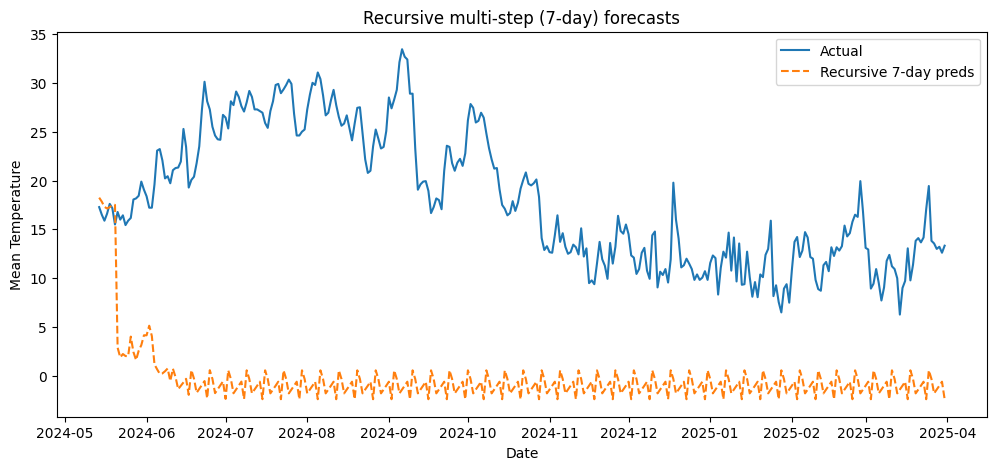

In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# 0) hyperparams
n_timesteps = 30
n_future    = 7        # predict 7 days ahead
batch_size  = 128
epochs      = 100

# 1) BUILD TRAIN FEATURES + TARGETS
df = df_train.copy()  # your original df_train with a 'mean' column

# --- add moving averages:
df['ma7']  = df['mean'].rolling(7).mean()
df['ma14'] = df['mean'].rolling(14).mean()
# drop initial NaNs
df = df.dropna().reset_index(drop=True)

# split into raw arrays
feat_cols = ['mean','ma7','ma14']
data_feats = df[feat_cols].values
data_target = df[['mean']].values

# --- scale each feature independently
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
data_feats = scaler_X.fit_transform(data_feats)
data_target = scaler_y.fit_transform(data_target)

# --- multi-step sequence builder
def create_multi_step(data_feats, data_target, n_timesteps, n_future):
    X, Y = [], []
    for i in range(len(data_feats) - n_timesteps - n_future + 1):
        X.append(data_feats[i : i + n_timesteps])
        # targets are the next n_future days of the **mean**
        Y.append(data_target[i+n_timesteps : i+n_timesteps+n_future, 0])
    return np.array(X), np.array(Y)

X_train, y_train = create_multi_step(data_feats, data_target, n_timesteps, n_future)
print(X_train.shape, y_train.shape)  
# → (samples, 30, 3), (samples, 7)

# 2) BUILD & TRAIN THE multi‐step LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(n_timesteps, len(feat_cols))),
    LSTM(50),
    Dense(n_future, activation='linear')   # output 7 values
])
model.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

model.fit(
    X_train, y_train,
    validation_split=0.05,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[es],
    verbose=2
)

# 3) RECURSIVE MULTI‐STEP FORECAST ON TEST
df_test2 = df_test.copy()
# add the same moving‐average features (use true past for MA)
df_test2['ma7']  = df_test2['mean'].rolling(7).mean()
df_test2['ma14'] = df_test2['mean'].rolling(14).mean()
df_test2 = df_test2.dropna().reset_index(drop=True)

# scale features
test_feats = scaler_X.transform(df_test2[feat_cols].values)
# we’ll keep a rolling “window” of length 30
window = test_feats[:n_timesteps].copy()

predictions = []
# forecast until we run out of test data
while len(predictions) + n_timesteps + n_future - 1 <= len(test_feats):
    # build one sample
    Xw = window.reshape(1, n_timesteps, len(feat_cols))
    yw = model.predict(Xw)[0]  # length-7 array of scaled mean
    # **invert scale** for just the mean:
    pred7 = scaler_y.inverse_transform(yw.reshape(-1,1)).flatten()
    predictions.extend(pred7)
    # now append the _scaled_ predictions back into window,
    # and drop the first n_future entries
    pred7_scaled = yw.reshape(-1,1)
    # we need full feature‐vectors for those 7 new days:
    # *mean* = pred7_scaled
    # *ma7, ma14* we approximate from previous window + these preds:
    fake_feats = []
    full_mean_series = list(window[:,0]) + list(pred7_scaled[:,0])
    for j in range(n_future):
        idx = len(full_mean_series) - n_future + j
        mean_j = full_mean_series[idx]
        ma7_j  = np.mean(full_mean_series[idx-7:idx])   # rolling 7‐day
        ma14_j = np.mean(full_mean_series[idx-14:idx]) # rolling 14‐day
        fake_feats.append([mean_j, ma7_j, ma14_j])
    fake_feats = np.array(fake_feats)
    fake_feats = scaler_X.transform(fake_feats)  # re‐scale
    # slide the window:
    window = np.vstack([window[n_future:], fake_feats])

# after the recursive loop
P = len(predictions)

# the very first prediction corresponds to df_test2 index = n_timesteps
start_idx = n_timesteps

# grab exactly P dates (and P true values) from there
dates     = pd.to_datetime(df_test2['date']).iloc[start_idx : start_idx + P].reset_index(drop=True)
true_vals = df_test2['mean'].iloc[start_idx : start_idx + P].values

# sanity check
assert len(dates) == P
assert len(true_vals) == P

plt.figure(figsize=(12,5))
plt.plot(dates, true_vals,     label='Actual')
plt.plot(dates, predictions,   label='Recursive 7-day preds', linestyle='--')
plt.legend()
plt.title("Recursive multi-step (7-day) forecasts")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.show()

X shape (33243, 30, 3) y shape (33243, 1)
Epoch 1/100


/opt/anaconda3/envs/tf-env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


247/247 - 7s - 29ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 2/100
247/247 - 6s - 23ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 3/100
247/247 - 6s - 23ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 4/100
247/247 - 6s - 24ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 5/100
247/247 - 6s - 23ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 6/100
247/247 - 6s - 23ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 7/100
247/247 - 6s - 24ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 8/100
247/247 - 6s - 23ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 9/100
247/247 - 6s - 24ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 10/100
247/247 - 6s - 23ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 11/100
247/247 - 6s - 24ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 12/100
247/247 - 6s - 23ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 13/100
247/247 - 6s - 23ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 14/100
247/247 - 6s - 24ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 15/100


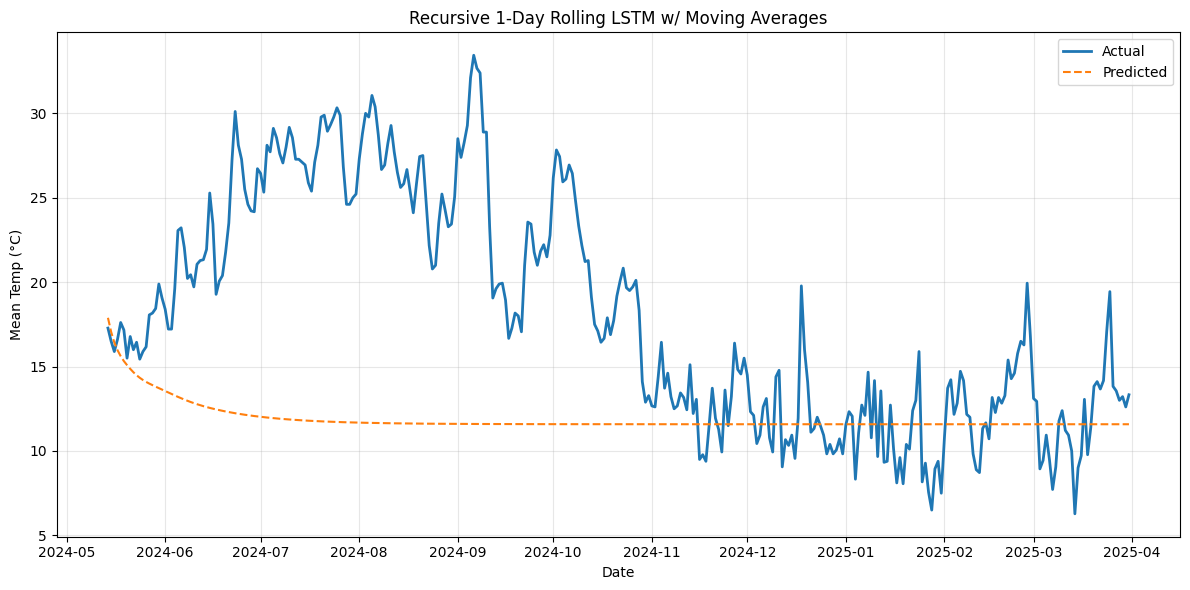

In [16]:
# --- 0) Prepare train‐time features + targets ---
df_train_feat = df_train.copy()

# compute moving averages
df_train_feat['ma7']  = df_train_feat['mean'].rolling(7).mean()
df_train_feat['ma14'] = df_train_feat['mean'].rolling(14).mean()
df_train_feat.dropna(inplace=True)   # drop the NaNs at the top

# feature & target columns
feat_cols = ['mean','ma7','ma14']
target_col = ['mean']

# scale
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_all = scaler_X.fit_transform(df_train_feat[feat_cols].values)
y_all = scaler_y.fit_transform(df_train_feat[target_col].values)

# build 30→1 sequences
def create_sequences_multi(feats, target, n_timesteps):
    X, y = [], []
    for i in range(len(feats) - n_timesteps):
        X.append(feats[i : i + n_timesteps])
        y.append(target[i + n_timesteps])
    return np.array(X), np.array(y)

n_timesteps = 30
X, y = create_sequences_multi(X_all, y_all, n_timesteps)
print("X shape", X.shape, "y shape", y.shape)  # (samples, 30, 3), (samples,1)

# --- 1) Train a 3-feature LSTM exactly as before ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import AdamW

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(n_timesteps, len(feat_cols))),
    LSTM(50),
    Dense(1, activation='elu')
])
model.compile(optimizer=AdamW(), loss='mse')

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
ck = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')

model.fit(X, y,
          epochs=100,
          batch_size=128,
          validation_split=0.05,
          callbacks=[es,ck],
          verbose=2)


# --- 2) Prepare your test‐time feature matrix (with MA’s) ---
df_test_feat = df_test.copy()
df_test_feat['ma7']  = df_test_feat['mean'].rolling(7).mean()
df_test_feat['ma14'] = df_test_feat['mean'].rolling(14).mean()
df_test_feat.dropna(inplace=True)  

test_feats = scaler_X.transform(df_test_feat[feat_cols].values)
dates      = df_test_feat['date'].iloc[n_timesteps:].reset_index(drop=True)


# --- 3) Recursive 1-day rollout over the scaled test features ---
history = list(test_feats[:n_timesteps])   # seed with first 30 “true” feature-rows
preds_scaled = []

for t in range(n_timesteps, len(test_feats)):
    x = np.array(history[-n_timesteps:]).reshape(1, n_timesteps, len(feat_cols))
    yhat = model.predict(x, verbose=0)[0,0]
    preds_scaled.append(yhat)
    
    # now build the next feature‐vector [mean, ma7, ma14]
    all_means = [row[0] for row in history] + [yhat]
    new_ma7   = np.mean(all_means[-7:])
    new_ma14  = np.mean(all_means[-14:])
    next_feat = np.array([yhat, new_ma7, new_ma14])
    history.append(next_feat)


# invert‐scale
preds = scaler_y.inverse_transform(np.array(preds_scaled).reshape(-1,1)).flatten()
actual = scaler_y.inverse_transform(
    test_feats[n_timesteps:,0].reshape(-1,1)
).flatten()


# --- 4) compare & plot ---
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

cmp = pd.DataFrame({
    'Actual':    actual,
    'Predicted': preds
}, index=dates)

print("MSE:", mean_squared_error(cmp.Actual, cmp.Predicted))
print("MAE:", mean_absolute_error(cmp.Actual, cmp.Predicted))
print("R2: ", r2_score(cmp.Actual, cmp.Predicted))

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(cmp.index, cmp.Actual,    label='Actual',   linewidth=2)
plt.plot(cmp.index, cmp.Predicted, label='Predicted', linestyle='--')
plt.title("Recursive 1-Day Rolling LSTM w/ Moving Averages")
plt.xlabel("Date"); plt.ylabel("Mean Temp (°C)")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()

### LSTM Testing 3 Months (Incorrect)

Doing it only for HDD and CDD timeframes

In [22]:
def create_test_sequences(data, n_timesteps):
    X_seq = []
    for i in range(len(data) - n_timesteps):
        X_seq.append(data[i:i+n_timesteps])
    return np.array(X_seq)

features = ['mean'] # Use only the 'mean' temperature column for testing, since only want to predict one feature. IMPORTANT


In [23]:

df_test['date'] = pd.to_datetime(df_test['date'])
df_test_scaled['date'] = df_test['date']  # carry over dates for indexing

# ——— Filter test set to Jun–Aug 2024 and Dec 2024–Mar 3 2025 ———
mask = (
    ((df_test['date'] >= "2024-06-01") & (df_test['date'] <= "2024-08-31")) |
    ((df_test['date'] >= "2024-12-01") & (df_test['date'] <= "2025-03-03"))
)
df_test        = df_test.loc[mask].reset_index(drop=True)
df_test_scaled = df_test_scaled.loc[mask].reset_index(drop=True)

print("Filtered test covers:", df_test['date'].min(), "to", df_test['date'].max())


Filtered test covers: 2024-06-01 00:00:00 to 2025-03-03 00:00:00


In [24]:
# --- 1) Build your test input from df_test_scaled, not raw df_test ---
X_test = create_test_sequences(
    df_test_scaled[['mean']].values,   # already scaled by y_scaler
    n_timesteps
)
print("Shape of X_test:", X_test.shape)

# --- 2) Predict in scaled space ---
predictions_scaled = model.predict(X_test)    # shape = (n_windows, 1)

# --- 3) Inverse-transform only with your y_scaler ---
predictions_original = y_scaler.inverse_transform(predictions_scaled)

# --- 4) Build a DataFrame of predictions ---
predictions_df = pd.DataFrame(predictions_original, columns=['mean'])
print("Predicted Temperatures (Original Scale):")
print(predictions_df.head())

# --- 5) Grab the true, scaled test values and inverse-transform them ---
actual_scaled = df_test_scaled[['mean']].values[n_timesteps:]
actual_original = y_scaler.inverse_transform(actual_scaled)
actual_df = pd.DataFrame(actual_original, columns=['mean'])

# --- 6) Align and compare ---
comparison_df = pd.concat(
    [actual_df.reset_index(drop=True), predictions_df.reset_index(drop=True)],
    axis=1
)

pd.set_option('display.max_rows', None)
comparison_df.columns = ['Actual mean', 'Predicted mean']
print("Comparison of Actual vs Predicted Temperatures:")
print(str(comparison_df))

print("MSE:", mean_squared_error(comparison_df['Actual mean'],
                                 comparison_df['Predicted mean']))
print("RMSE:", np.sqrt(mean_squared_error(comparison_df['Actual mean'],
                                         comparison_df['Predicted mean'])))
print("MAE:", mean_absolute_error(comparison_df['Actual mean'],
                                  comparison_df['Predicted mean']))
print("R2: ", r2_score(comparison_df['Actual mean'],
                       comparison_df['Predicted mean']))

Shape of X_test: (155, 30, 1)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Predicted Temperatures (Original Scale):
        mean
0  27.385572
1  25.809629
2  24.714869
3  28.694626
4  26.878365
Comparison of Actual vs Predicted Temperatures:
     Actual mean  Predicted mean
0          26.44       27.385572
1          25.33       25.809629
2          28.11       24.714869
3          27.72       28.694626
4          29.11       26.878365
5          28.56       28.899319
6          27.61       27.631788
7          27.06       26.799540
8          28.00       26.609705
9          29.17       27.921356
10         28.56       28.936516
11         27.28       27.712994
12         27.28       26.523943
13         27.11       27.062393
14         26.94       26.835724
15         25.89       26.688770
16         25.39       25.480202
17         27.11       25.308077
18         28.11       27.621862
19         29.78       27.993040
20         29.89       29.599468
21         28.94       29.057301
22    

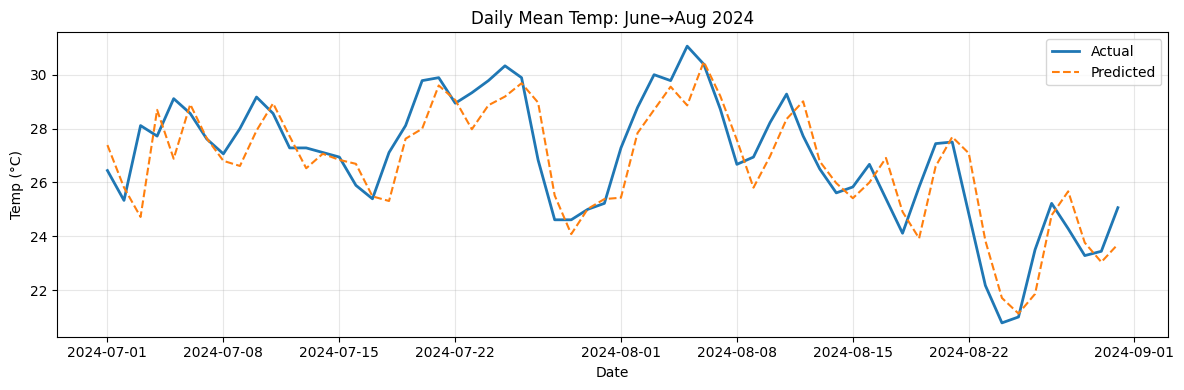

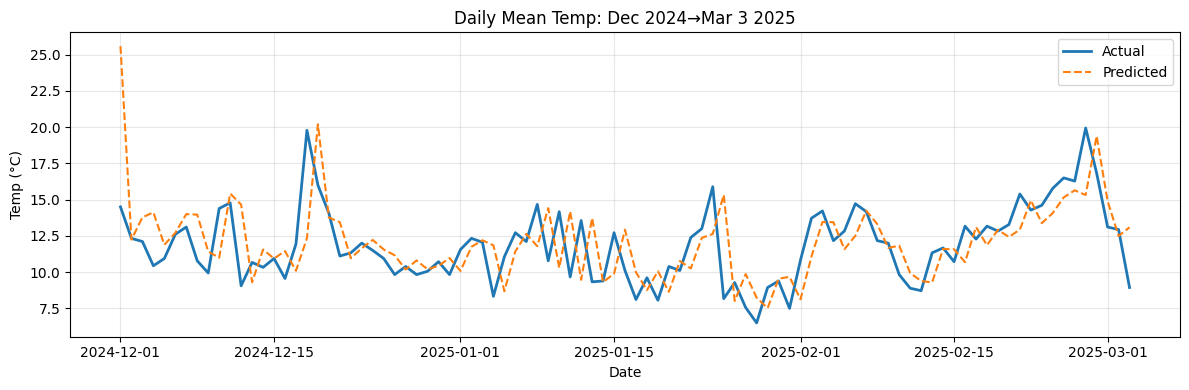

In [28]:
# Make 'Date' the index
comparison_df.set_index("Date", inplace=True)

# 1) Slice into the two 3-month windows
p1 = comparison_df.loc["2024-06-01":"2024-08-31"]
p2 = comparison_df.loc["2024-12-01":"2025-03-03"]

# 2) Plot Window 1: June–Aug 2024
plt.figure(figsize=(12,4))
plt.plot(p1.index, p1["Actual mean"],   label="Actual",  linewidth=2)
plt.plot(p1.index, p1["Predicted mean"], label="Predicted", linestyle="--")
plt.title("Daily Mean Temp: June→Aug 2024")
plt.xlabel("Date"); plt.ylabel("Temp (°C)")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()

# 3) Plot Window 2: Dec 2024–Mar 3 2025
plt.figure(figsize=(12,4))
plt.plot(p2.index, p2["Actual mean"],   label="Actual",  linewidth=2)
plt.plot(p2.index, p2["Predicted mean"], label="Predicted", linestyle="--")
plt.title("Daily Mean Temp: Dec 2024→Mar 3 2025")
plt.xlabel("Date"); plt.ylabel("Temp (°C)")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()

### Room for Improvement 

Room for Improvement: LSTM
- Hyperparameter tuning
- Increasing epochs
- Increasing layers
- Increasing windowing span
- Modify batch size
- Changing activation function -> tried many, so far elu performs best